In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
import os

In [2]:
#定义图片预处理方法
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [3]:
#训练数据和标签
trainset = datasets.ImageFolder('faces', data_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,shuffle=True, num_workers=4)

In [4]:
#显示图片
def imshow(inputs,picname):
    inputs = inputs.cpu()
    plt.ion()
    inputs = inputs / 2 + 0.5
    inputs = inputs.numpy().transpose((1, 2, 0))
    plt.imshow(inputs)
    plt.pause(0.01)

    plt.savefig(os.path.join('faces', '0',picname+".jpg"))
    plt.close()

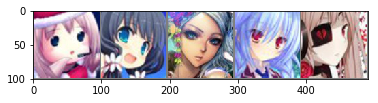

In [5]:
inputs,__ = next(iter(trainloader))
imshow(torchvision.utils.make_grid(inputs),"RealDataSample")

In [6]:
#定义鉴别器
class D(nn.Module):
    def __init__(self,nc,ndf):
        super(D, self).__init__()
        #网络包含四个卷积层和一个二元分类
        #Sequential是一个有序容器，可以将其中的网络模型依次执行。顺序为卷积，批归一化，激活函数
        self.layer1 = nn.Sequential(nn.Conv2d(nc,ndf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf),
                                 nn.LeakyReLU(0.2,inplace=True))
        self.layer2 = nn.Sequential(nn.Conv2d(ndf,ndf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*2),
                                 nn.LeakyReLU(0.2,inplace=True))
        self.layer3 = nn.Sequential(nn.Conv2d(ndf*2,ndf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*4),
                                 nn.LeakyReLU(0.2,inplace=True))
        self.layer4 = nn.Sequential(nn.Conv2d(ndf*4,ndf*8,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ndf*8),
                                 nn.LeakyReLU(0.2,inplace=True))
        #二元分类
        self.fc = nn.Sequential(nn.Linear(256*6*6,1),nn.Sigmoid())
      #前向传播 
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(-1,256*6*6)
        out = self.fc(out)
        return out


In [7]:
#定义生成器
class G(nn.Module):
    def __init__(self,nc, ngf,nz,feature_size):
        super(G,self).__init__()
        self.prj = nn.Linear(feature_size,nz*6*6)
        #四层反卷积
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(nz,ngf*4,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*4),
                                 nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(ngf*4,ngf*2,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf*2),
                                 nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(ngf*2,ngf,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(ngf),
                                 nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(ngf,nc,kernel_size=4,stride=2,padding=1),
                                 nn.Tanh())
    
    def forward(self,x):
        out = self.prj(x)
        out = out.view(-1,1024,6,6)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out


In [8]:
# CUDA = torch.cuda.is_available()
# if CUDA:
#     d = D(3,32).cuda()
#     g = G(3,128,1024,100).cuda()
# else:
#     d = D(3,32)
#     g = G(3,128,1024,100)
d = D(3,32).cuda()
g = G(3,128,1024,100).cuda()

In [9]:
#交叉熵函数作为损失函数
criterion = nn.BCELoss()
#Adam优化器
d_optimizer = torch.optim.Adam(d.parameters(),lr=0.0003)
g_optimizer = torch.optim.Adam(g.parameters(),lr=0.0003)

In [10]:
def train(d,g,criterion,d_optimizer,g_optimizer,epochs=1,show_every=1000,print_every=10):
    iter_count = 0
    for epoch in range(epochs):    #训练次数
        
        for inputs,_ in trainloader:

            real_inputs = inputs.cuda()

            fake_inputs = g(torch.randn(5,100).cuda())
            
            real_labels = torch.ones(real_inputs.size(0)).cuda()
            fake_labels = torch.zeros(5).cuda()
            
            real_outputs = d(real_inputs)
            d_loss_real = criterion(real_outputs,real_labels)
            real_scores = real_outputs

            fake_outputs = d(fake_inputs)
            d_loss_fake = criterion(fake_outputs,fake_labels)
            fake_scores = fake_outputs


            d_loss = d_loss_real+d_loss_fake
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
        
            fake_inputs = g(torch.randn(5,100).cuda())
            outputs = d(fake_inputs)
            real_labels = torch.ones(outputs.size(0)).cuda()
            g_loss = criterion(outputs,real_labels)
            
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if (iter_count % show_every == 0):
                print('Epoch:{},Iter: {}, D: {:.4}, G:{:.4}'.format(epoch,iter_count, d_loss.item(), g_loss.item()))
                picname = "Epoch_"+str(epoch)+"Iter_"+str(iter_count)
                imshow(torchvision.utils.make_grid(fake_inputs.data),picname)
                save_param(d,'d_model.pkl')
                save_param(g,'g_model.pkl')

            if (iter_count%print_every == 0):
                print('Epoch:{},Iter: {}, D: {:.4}, G:{:.4}'.format(epoch,iter_count, d_loss.item(), g_loss.item()))
            iter_count += 1
        
    print('Finished Training')

In [11]:
#加载模型
def load_param(model,path):
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))


In [12]:
#保存模型
def save_param(model,path):
    torch.save(model.state_dict(),path)

In [13]:
if os.path.exists("d_model.pkl"):
    load_param(d,'d_model.pkl')
    load_param(g,'g_model.pkl')

Epoch:0,Iter: 0, D: 1.004, G:4.772


E:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


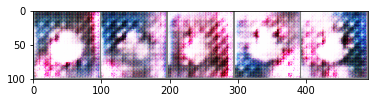

Epoch:0,Iter: 0, D: 1.004, G:4.772
Epoch:0,Iter: 10, D: 1.687, G:2.117
Epoch:0,Iter: 20, D: 1.28, G:2.19
Epoch:0,Iter: 30, D: 0.1107, G:2.523
Epoch:0,Iter: 40, D: 1.024, G:4.321
Epoch:0,Iter: 50, D: 0.9215, G:4.806
Epoch:0,Iter: 60, D: 1.321, G:4.682
Epoch:0,Iter: 70, D: 1.636, G:0.9284
Epoch:0,Iter: 80, D: 1.098, G:5.195
Epoch:0,Iter: 90, D: 0.2706, G:4.316
Epoch:0,Iter: 100, D: 1.705, G:1.245
Epoch:0,Iter: 110, D: 0.8723, G:0.9555
Epoch:0,Iter: 120, D: 1.144, G:3.738
Epoch:0,Iter: 130, D: 1.01, G:4.215
Epoch:0,Iter: 140, D: 0.8391, G:5.059
Epoch:0,Iter: 150, D: 0.252, G:3.942
Epoch:0,Iter: 160, D: 0.8268, G:4.951
Epoch:0,Iter: 170, D: 1.169, G:7.627
Epoch:0,Iter: 180, D: 0.3053, G:5.299
Epoch:0,Iter: 190, D: 0.5301, G:7.995
Epoch:0,Iter: 200, D: 3.771, G:3.541
Epoch:0,Iter: 210, D: 0.4283, G:6.108
Epoch:0,Iter: 220, D: 0.6027, G:3.991
Epoch:0,Iter: 230, D: 0.2387, G:4.166
Epoch:0,Iter: 240, D: 0.08085, G:2.81
Epoch:0,Iter: 250, D: 0.07303, G:3.362
Epoch:0,Iter: 260, D: 0.3753, G:3.71

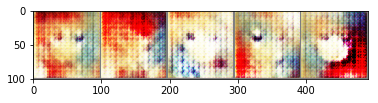

Epoch:0,Iter: 1000, D: 0.1188, G:3.708
Epoch:0,Iter: 1010, D: 0.1392, G:5.226
Epoch:0,Iter: 1020, D: 0.5649, G:1.015
Epoch:0,Iter: 1030, D: 0.491, G:0.9706
Epoch:0,Iter: 1040, D: 0.6059, G:1.957
Epoch:0,Iter: 1050, D: 0.6037, G:1.503
Epoch:0,Iter: 1060, D: 0.8346, G:4.29
Epoch:0,Iter: 1070, D: 0.4591, G:3.559
Epoch:0,Iter: 1080, D: 1.781, G:1.601
Epoch:0,Iter: 1090, D: 0.2202, G:6.737
Epoch:0,Iter: 1100, D: 0.1905, G:4.244
Epoch:0,Iter: 1110, D: 0.671, G:4.216
Epoch:0,Iter: 1120, D: 0.4238, G:3.952
Epoch:0,Iter: 1130, D: 1.777, G:1.831
Epoch:0,Iter: 1140, D: 0.3802, G:4.852
Epoch:0,Iter: 1150, D: 0.25, G:4.147
Epoch:0,Iter: 1160, D: 0.5314, G:3.326
Epoch:0,Iter: 1170, D: 0.4252, G:3.75
Epoch:0,Iter: 1180, D: 0.8558, G:3.141
Epoch:0,Iter: 1190, D: 0.4882, G:2.731
Epoch:0,Iter: 1200, D: 0.9311, G:1.0
Epoch:0,Iter: 1210, D: 1.053, G:3.681
Epoch:0,Iter: 1220, D: 0.6826, G:4.66
Epoch:0,Iter: 1230, D: 0.3795, G:3.379
Epoch:0,Iter: 1240, D: 1.061, G:3.93
Epoch:0,Iter: 1250, D: 0.4083, G:3.537

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "E:\Anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "E:\Anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "E:\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "E:\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "E:\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 96 and 288 in dimension 2 at C:\w\1\s\tmp_conda_3.6_081743\conda\conda-bld\pytorch_1572941935551\work\aten\src\TH/generic/THTensor.cpp:689


In [14]:
train(d,g,criterion,d_optimizer,g_optimizer,epochs=300)

save_param(d,'d_model.pkl')
save_param(g,'g_model.pkl')